# Benchmark Llama2 models on the ClimateX task and dataset

To do this, we will utilize Together.ai for Llama 2 model APIs.



In [1]:
import pandas as pd 
import re
import os


In [2]:
# API Keys - store your TOGETHER_API_KEY in local .env file in this directory
from dotenv import load_dotenv
load_dotenv()


True

In [3]:
df = pd.read_csv('./data/ipcc_statements_dataset.tsv', sep='\t', skiprows=0)

train_set = df.loc[df['split'] == 'train']
test_set = df.loc[df['split'] == 'test']

test_set.head()

,statement_idx,report,page_num,sent_num,statement,confidence,score,split
3,3,AR6_WGI,24,2,"Since 1750, increases in CO2 (47%) and CH4 (15...",very high,3,test
42,42,AR6_WGI,37,16,"Over the next 2000 years, global mean sea leve...",low,0,test
77,77,AR6_WGI,47,7,"By the end of the century, scenarios with very...",high,2,test
81,81,AR6_WGI,62,2,"Over the past millennium, and especially since...",medium,1,test
86,86,AR6_WGI,63,8,The paleo context supports the assessment that...,high,2,test


In [4]:
from langchain.llms import Together

llm = Together(
    # Select one.
    # model = "togethercomputer/llama-2-7b-chat",
    # model = "togethercomputer/llama-2-13b-chat", 
    model = "togethercomputer/llama-2-70b-chat", 
    temperature=0.0,
)


## First, use zero-shot prompting (no examples)

In [5]:
# ZERO_SHOT_PROMPT = """You are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change.

# You will be presented with a statement about climate science, climate impacts or climate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?

# Respond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.      

# ---

# Follow the following format.

# Statement: ${{a short statement about climate.}}
# Confidence: ${{must be *only*: 'low', 'medium', 'high', 'very high'}}

# ---

# Statement: {input}
# Confidence: """

ZERO_SHOT_PROMPT = """You are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change.

You will be presented with a statement about climate science, climate impacts or climate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?

Respond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.      

---

Follow the following format.

Statement: ${{a short statement about climate.}}
Confidence: ${{must be *only*: 'low', 'medium', 'high', 'very high'}}

---

Statement: {input}
Confidence: """

### One example

In [6]:
def get_zero_shot_confidence(llm, prompt, statement, verbose=False):
    complete_prompt = prompt.format(input=statement)
    text = llm(complete_prompt)
    if verbose:
        print("--PROMPT--")
        print(complete_prompt)
        print()

        print("--MODEL RESPONSE--")
        print(text)
        print("--FINAL PARSED OUTPUT CONFIDENCE PREDICTION--")

    # extract single-word confidence rating
    if re.search(r"low", text, re.IGNORECASE):
        return "low"
    elif re.search(r"medium", text, re.IGNORECASE):
        return "medium"
    elif re.search(r"very high", text, re.IGNORECASE):
        return "very high"
    elif re.search(r"high", text, re.IGNORECASE):
        return "high"
    elif re.search(r"i don't know", text, re.IGNORECASE):
        return "idk"
    else:
        return "N/A"

example = train_set['statement'].sample(1)
example = example.values[0]
get_zero_shot_confidence(llm, ZERO_SHOT_PROMPT, example, verbose=True)

--PROMPT--
You are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change.

You will be presented with a statement about climate science, climate impacts or climate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?

Respond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.      

---

Follow the following format.

Statement: ${a short statement about climate.}
Confidence: ${must be *only*: 'low', 'medium', 'high', 'very high'}

---

Statement: Changing availability of traditional foods and forced diet change (medium confiden

'N/A'

## Run on the entire test set, save results

In [7]:
samples = test_set.copy()

samples['prediction'] = samples.statement.apply(lambda x: get_zero_shot_confidence(llm, ZERO_SHOT_PROMPT, x))

In [8]:
samples['correct'] = samples.apply(
    lambda row: (row['confidence'] == row['prediction']), axis=1)

print(f"Accuracy: {samples['correct'].sum() / (samples.shape[0]-len(samples[samples['prediction'] == 'idk'])):.3f}")
print(f"'I don't know': {len(samples[samples['prediction'] == 'idk'])}")
print(f"N/A: {len(samples[samples['prediction'] == 'N/A'])}")

Accuracy: 0.080
'I don't know': 0
N/A: 216


In [9]:
samples.to_csv('./results/llama-2-chat-70b-zeroshot-temp0-2023-12-21.csv', index=False)

In [10]:
display(samples[samples['prediction'] == 'idk'])

,statement_idx,report,page_num,sent_num,statement,confidence,score,split,prediction,correct


In [11]:
display(samples[samples['prediction'] == 'N/A'])

,statement_idx,report,page_num,sent_num,statement,confidence,score,split,prediction,correct
3,3,AR6_WGI,24,2,"Since 1750, increases in CO2 (47%) and CH4 (15...",very high,3,test,N/A,False
42,42,AR6_WGI,37,16,"Over the next 2000 years, global mean sea leve...",low,0,test,N/A,False
77,77,AR6_WGI,47,7,"By the end of the century, scenarios with very...",high,2,test,N/A,False
81,81,AR6_WGI,62,2,"Over the past millennium, and especially since...",medium,1,test,N/A,False
86,86,AR6_WGI,63,8,The paleo context supports the assessment that...,high,2,test,N/A,False
...,...,...,...,...,...,...,...,...,...,...
7875,7875,AR6_WGIII,1257,34,The production of synthetic fuels using low-ca...,low,0,test,N/A,False
7914,7914,AR6_WGIII,1673,3,"In some cases, notably with respect to aviatio...",high,2,test,N/A,False
7931,7931,AR6_WGIII,1769,15,"In addition to indirect and direct subsidies, ...",high,2,test,N/A,False
8024,8024,AR6_WGIII,1827,13,REDD+ can significantly contribute to climate ...,high,2,test,N/A,False


## Precision, recall, and F1 score

In [12]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report

true_labels = samples.loc[(samples['prediction'] != 'N/A') & (samples['prediction'] != 'idk'), 'confidence']
predicted_labels = samples.loc[(samples['prediction'] != 'N/A') & (samples['prediction'] != 'idk'), 'prediction']

# Compute macro F1 score
f1 = f1_score(true_labels, predicted_labels, average='macro')
print("Macro F1 score:", f1)

# Compute weighted F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print("Weighted F1 score:", f1)

# Compute precision for each class
precision = precision_score(true_labels, predicted_labels, average=None)

# Compute recall for each class
recall = recall_score(true_labels, predicted_labels, average=None)

# Compute F1 score for each class
f1 = f1_score(true_labels, predicted_labels, average=None)

# Create a dataframe to store precision and recall for each class
class_metrics_df = pd.DataFrame({'Precision': precision, 'Recall': recall, 'F1': f1})

# Add labels to the class metrics dataframe
class_metrics_df['Class'] = true_labels.unique().astype(str)

# Sort the dataframe by class index or name
class_metrics_df = class_metrics_df.sort_values('Class', key=lambda x: pd.Categorical(x, categories=["low", "medium", "high", "very high"]))

# Print class metrics dataframe
#print(class_metrics_df)

# Compute accuracy for the whole system
accuracy = accuracy_score(true_labels, predicted_labels)

# Compute accuracy by class

print("Accuracy (total):", accuracy)

report = classification_report(true_labels, predicted_labels, digits=4)
print(report)

# Count classes
category_counts = true_labels.value_counts()
print(category_counts)



Macro F1 score: 0.24664704664704665
Weighted F1 score: 0.2435347578204721
Accuracy (total): 0.2857142857142857
              precision    recall  f1-score   support

        high     0.5625    0.3913    0.4615        23
         low     0.2281    0.6500    0.3377        20
      medium     0.1429    0.0333    0.0541        30
   very high     0.2500    0.0909    0.1333        11

    accuracy                         0.2857        84
   macro avg     0.2959    0.2914    0.2466        84
weighted avg     0.2921    0.2857    0.2435        84

confidence
medium       30
high         23
low          20
very high    11
Name: count, dtype: int64


## Over/under confidence assessment

In [13]:
# Filter samples
fs = samples.loc[(samples['prediction'] != 'N/A') & (samples['prediction'] != 'idk')] 

# Compute a certainty score
value_map = {'low': 0, 'medium': 1, 'high': 2, 'very high': 3}

fs['predicted_score'] = fs.prediction.apply(
    lambda x: value_map[x])

# Break down scores
scores_all = {
    "low": fs.loc[fs['score'] == 0, 'predicted_score'].mean(),
    "medium": fs.loc[fs['score'] == 1, 'predicted_score'].mean(),
    "high": fs.loc[fs['score'] == 2, 'predicted_score'].mean(),
    "very high": fs.loc[fs['score'] == 3, 'predicted_score'].mean()
}

scores_wg1 = {
    "low": fs.loc[(fs['score'] == 0) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "medium": fs.loc[(fs['score'] == 1) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "high": fs.loc[(fs['score'] == 2) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "very high": fs.loc[(fs['score'] == 3) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean()
}

scores_wg23 = {
    "low": fs.loc[(fs['score'] == 0) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "medium": fs.loc[(fs['score'] == 1) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "high": fs.loc[(fs['score'] == 2) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "very high": fs.loc[(fs['score'] == 3) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean()
}

print("=== All AR6 reports===")
print(f"Average ground truth score: {samples['score'].mean()}")
print(f"Average predicted score: {fs['predicted_score'].mean()}")
print(f"Average scores per category: {scores_all}\n")

print("=== AR6 WGI report ===")
print(f"Average ground truth score: {samples.loc[samples['report'] == 'AR6_WGI', 'score'].mean()}")
print(f"Average predicted score: {fs.loc[fs['report'] == 'AR6_WGI', 'predicted_score'].mean()}")
print(f"Average scores per category: {scores_wg1}\n")

print("=== AR6 WGII/III reports ===")
print(f"Average ground truth score: {samples.loc[samples['report'] != 'AR6_WGI', 'score'].mean()}")
print(f"Average predicted score: {fs.loc[fs['report'] != 'AR6_WGI', 'predicted_score'].mean()}")
print(f"Average scores per category: {scores_wg23}\n")

=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 0.6071428571428571
Average scores per category: {'low': 0.45, 'medium': 0.26666666666666666, 'high': 1.0434782608695652, 'very high': 0.9090909090909091}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 0.5
Average scores per category: {'low': 0.625, 'medium': 0.0, 'high': 0.8571428571428571, 'very high': 2.0}

=== AR6 WGII/III reports ===
Average ground truth score: 1.5853658536585367
Average predicted score: 0.6551724137931034
Average scores per category: {'low': 0.3333333333333333, 'medium': 0.4, 'high': 1.125, 'very high': 0.8}



/var/folders/zw/vnb4lkhd14n9cx0d71_qh_z00000gn/T/ipykernel_29226/201967900.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fs['predicted_score'] = fs.prediction.apply(


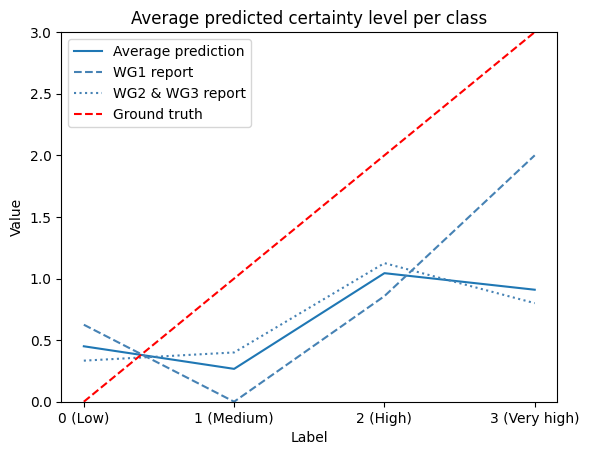

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the data

# Extract labels and values from the data dictionary
labels = list(scores_all.keys())
values_all = list(scores_all.values())
values_wg1 = list(scores_wg1.values())
values_wg23 = list(scores_wg23.values())

# Define the custom labels for the x-axis
x_labels = ['0 (Low)', '1 (Medium)', '2 (High)', '3 (Very high)']

# Create the line plot with labeled curve
sns.lineplot(x=labels, y=values_all, label='Average prediction')
sns.lineplot(x=labels, y=values_wg1, linestyle='--', color="steelblue", label='WG1 report')
sns.lineplot(x=labels, y=values_wg23, linestyle='dotted', color="steelblue", label='WG2 & WG3 report')


# Add the ground truth line (y = x)
x = np.arange(len(labels))
plt.plot(x, x, linestyle='--', color='red', label='Ground truth')

# Customize the x-axis tick labels
plt.xticks(labels, x_labels)

# Set the y-axis limits
plt.ylim(0, 3)

# Set the title and labels
plt.title("Average predicted certainty level per class")
plt.xlabel("Label")
plt.ylabel("Value")

# Show the legend
plt.legend()

# Show the plot
plt.show()

## Try Few-shot prompting

In [15]:
FEW_SHOT_PROMPT = """You are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change.

You will be presented with a statement about climate science, climate impacts or climate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?

Respond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.      

---

Follow the following format.

Statement: ${{a short statement about climate.}}
Confidence: ${{must be *only*: 'low', 'medium', 'high', 'very high'}}

---
{examples}

Statement: {input}
Confidence: """

In [16]:
EXAMPLE_TEMPLATE = """
Statement: {example_statement}
Confidence: {example_label}
"""

### One prompt example

In [17]:
def get_few_shot_confidence(llm, prompt, example_template, statement, n_examples=3, verbose=False):
    assert n_examples > 0, "Please use n_examples > 0 or choose get zero_shot_confidence"
    selected_examples = train_set.sample(n_examples)
    examples = ""
    for e, l in zip(selected_examples.statement, selected_examples.confidence):
        examples += example_template.format(example_statement = e, example_label=l)
    
    complete_prompt = prompt.format(examples=examples, input=statement)
    text = llm(complete_prompt)
    if verbose:
        print("--PROMPT--")
        print(complete_prompt)
        print()

        print("--MODEL RESPONSE--")
        print(text)
        print("--FINAL PARSED OUTPUT CONFIDENCE PREDICTION--")

    # extract single-word confidence rating
    if re.search(r"low", text, re.IGNORECASE):
        return "low"
    elif re.search(r"medium", text, re.IGNORECASE):
        return "medium"
    elif re.search(r"very high", text, re.IGNORECASE):
        return "very high"
    elif re.search(r"high", text, re.IGNORECASE):
        return "high"
    elif re.search(r"i don't know", text, re.IGNORECASE):
        return "idk"
    else:
        return "N/A"

statement = train_set['statement'].sample(1)
statement = statement.values[0]
get_few_shot_confidence(llm, FEW_SHOT_PROMPT, EXAMPLE_TEMPLATE, statement, n_examples = 3, verbose=True)

--PROMPT--
You are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change.

You will be presented with a statement about climate science, climate impacts or climate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?

Respond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.      

---

Follow the following format.

Statement: ${a short statement about climate.}
Confidence: ${must be *only*: 'low', 'medium', 'high', 'very high'}

---

Statement: Although permafrost persists in areas of the Northern Hemisphere where it was abse

'medium'

## Run on the entire test set, save results

In [18]:

samples = test_set.copy()

samples['prediction'] = samples.statement.apply(lambda x: get_few_shot_confidence(llm, FEW_SHOT_PROMPT, EXAMPLE_TEMPLATE, x, n_examples = 3))

In [19]:
samples['correct'] = samples.apply(
    lambda row: (row['confidence'] == row['prediction']), axis=1)

print(f"Accuracy: {samples['correct'].sum() / (samples.shape[0]-len(samples[samples['prediction'] == 'idk'])):.3f}")
print(f"'I don't know': {len(samples[samples['prediction'] == 'idk'])}")
print(f"N/A: {len(samples[samples['prediction'] == 'N/A'])}")

Accuracy: 0.110
'I don't know': 0
N/A: 175


In [20]:
samples.to_csv('./results/llama-2-chat-70b-fewshot-temp0-2023-12-21.csv', index=False)

## Precision, recall, and F1 score

In [21]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report

true_labels = samples.loc[(samples['prediction'] != 'N/A') & (samples['prediction'] != 'idk'), 'confidence']
predicted_labels = samples.loc[(samples['prediction'] != 'N/A') & (samples['prediction'] != 'idk'), 'prediction']

# Compute macro F1 score
f1 = f1_score(true_labels, predicted_labels, average='macro')
print("Macro F1 score:", f1)

# Compute weighted F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print("Weighted F1 score:", f1)

# Compute precision for each class
precision = precision_score(true_labels, predicted_labels, average=None)

# Compute recall for each class
recall = recall_score(true_labels, predicted_labels, average=None)

# Compute F1 score for each class
f1 = f1_score(true_labels, predicted_labels, average=None)

# Create a dataframe to store precision and recall for each class
class_metrics_df = pd.DataFrame({'Precision': precision, 'Recall': recall, 'F1': f1})

# Add labels to the class metrics dataframe
class_metrics_df['Class'] = true_labels.unique().astype(str)

# Sort the dataframe by class index or name
class_metrics_df = class_metrics_df.sort_values('Class', key=lambda x: pd.Categorical(x, categories=["low", "medium", "high", "very high"]))

# Print class metrics dataframe
#print(class_metrics_df)

# Compute accuracy for the whole system
accuracy = accuracy_score(true_labels, predicted_labels)

# Compute accuracy by class

print("Accuracy (total):", accuracy)

report = classification_report(true_labels, predicted_labels, digits=4)
print(report)

# Count classes
category_counts = true_labels.value_counts()
print(category_counts)



Macro F1 score: 0.24220268287328567
Weighted F1 score: 0.23571468647818
Accuracy (total): 0.264
              precision    recall  f1-score   support

        high     0.6000    0.0625    0.1132        48
         low     0.1923    0.5263    0.2817        19
      medium     0.3810    0.4211    0.4000        38
   very high     0.1538    0.2000    0.1739        20

    accuracy                         0.2640       125
   macro avg     0.3318    0.3025    0.2422       125
weighted avg     0.4001    0.2640    0.2357       125

confidence
high         48
medium       38
very high    20
low          19
Name: count, dtype: int64


## Over/under confidence assessment

In [22]:
# Filter samples
fs = samples.loc[(samples['prediction'] != 'N/A') & (samples['prediction'] != 'idk')] 

# Compute a certainty score
value_map = {'low': 0, 'medium': 1, 'high': 2, 'very high': 3}

fs['predicted_score'] = fs.prediction.apply(
    lambda x: value_map[x])

# Break down scores
scores_all = {
    "low": fs.loc[fs['score'] == 0, 'predicted_score'].mean(),
    "medium": fs.loc[fs['score'] == 1, 'predicted_score'].mean(),
    "high": fs.loc[fs['score'] == 2, 'predicted_score'].mean(),
    "very high": fs.loc[fs['score'] == 3, 'predicted_score'].mean()
}

scores_wg1 = {
    "low": fs.loc[(fs['score'] == 0) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "medium": fs.loc[(fs['score'] == 1) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "high": fs.loc[(fs['score'] == 2) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "very high": fs.loc[(fs['score'] == 3) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean()
}

scores_wg23 = {
    "low": fs.loc[(fs['score'] == 0) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "medium": fs.loc[(fs['score'] == 1) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "high": fs.loc[(fs['score'] == 2) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "very high": fs.loc[(fs['score'] == 3) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean()
}

print("=== All AR6 reports===")
print(f"Average ground truth score: {samples['score'].mean()}")
print(f"Average predicted score: {fs['predicted_score'].mean()}")
print(f"Average scores per category: {scores_all}\n")

print("=== AR6 WGI report ===")
print(f"Average ground truth score: {samples.loc[samples['report'] == 'AR6_WGI', 'score'].mean()}")
print(f"Average predicted score: {fs.loc[fs['report'] == 'AR6_WGI', 'predicted_score'].mean()}")
print(f"Average scores per category: {scores_wg1}\n")

print("=== AR6 WGII/III reports ===")
print(f"Average ground truth score: {samples.loc[samples['report'] != 'AR6_WGI', 'score'].mean()}")
print(f"Average predicted score: {fs.loc[fs['report'] != 'AR6_WGI', 'predicted_score'].mean()}")
print(f"Average scores per category: {scores_wg23}\n")

=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.04
Average scores per category: {'low': 1.0, 'medium': 1.105263157894737, 'high': 1.0416666666666667, 'very high': 0.95}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.0714285714285714
Average scores per category: {'low': 0.5555555555555556, 'medium': 1.35, 'high': 1.2222222222222223, 'very high': 0.6666666666666666}

=== AR6 WGII/III reports ===
Average ground truth score: 1.5853658536585367
Average predicted score: 1.0144927536231885
Average scores per category: {'low': 1.4, 'medium': 0.8333333333333334, 'high': 0.9333333333333333, 'very high': 1.1818181818181819}



/var/folders/zw/vnb4lkhd14n9cx0d71_qh_z00000gn/T/ipykernel_29226/201967900.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fs['predicted_score'] = fs.prediction.apply(


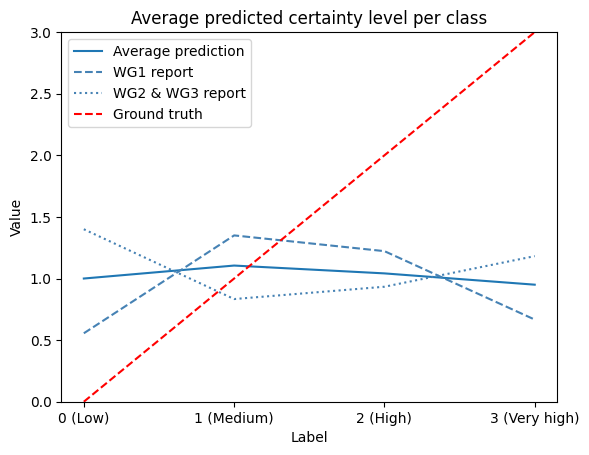

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the data

# Extract labels and values from the data dictionary
labels = list(scores_all.keys())
values_all = list(scores_all.values())
values_wg1 = list(scores_wg1.values())
values_wg23 = list(scores_wg23.values())

# Define the custom labels for the x-axis
x_labels = ['0 (Low)', '1 (Medium)', '2 (High)', '3 (Very high)']

# Create the line plot with labeled curve
sns.lineplot(x=labels, y=values_all, label='Average prediction')
sns.lineplot(x=labels, y=values_wg1, linestyle='--', color="steelblue", label='WG1 report')
sns.lineplot(x=labels, y=values_wg23, linestyle='dotted', color="steelblue", label='WG2 & WG3 report')


# Add the ground truth line (y = x)
x = np.arange(len(labels))
plt.plot(x, x, linestyle='--', color='red', label='Ground truth')

# Customize the x-axis tick labels
plt.xticks(labels, x_labels)

# Set the y-axis limits
plt.ylim(0, 3)

# Set the title and labels
plt.title("Average predicted certainty level per class")
plt.xlabel("Label")
plt.ylabel("Value")

# Show the legend
plt.legend()

# Show the plot
plt.show()